In [1]:
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihoods.poisson import PoissonLikelihood
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation
from epymorph.parameter_fitting.utils import plots

In [2]:
import numpy as np

In [3]:
from epymorph import *
from epymorph.adrio import acs5
from epymorph.adrio import commuting_flows
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.seir import Seir
from epymorph.data.mm.pei import Pei

# Describe the geographic scope of our simulation:
scope = StateScope.in_states(["AZ", "NM", "CO"], year=2015)
n_nodes = len(scope.includes)
initial_state = np.zeros(shape=(n_nodes, 4), dtype=np.int64)
initial_state[:, 0] = 100_000 - 10
initial_state[:, 1] = 20

rume = SingleStrataRume.build(
    # Load an IPM from the library
    ipm=Seir(),
    # Load an MM from the library
    mm=Pei(),
    # Use our scope
    scope=scope,
    init=init.Explicit(initials=initial_state),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2015-01-01", 120),
    # Provide parameter values
    params={
        "eta": 1 / 7,
        "gamma": 1 / 14,
        "q": 0.1,
        # Geographic data can be loaded using ADRIOs
        "population": acs5.Population(),
        "commuters": commuting_flows.Commuters(),
    },
)

In [4]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./synthetic_data_multinode.csv"),
    time_col=0,
    time_frame=TimeFrame.range("2015-01-01", "2015-04-30"),
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [5]:
from epymorph.simulator.data import evaluate_param

params = {}

for key in rume.params:
    params[key] = np.array(evaluate_param(rume, str(key)))

rume_copy = SingleStrataRume(
    strata=rume.strata,
    ipm=rume.ipm,
    mms=rume.mms,
    scope=rume.scope,
    time_frame=rume.time_frame,
    params=params,
)

In [6]:
rume.dim.nodes

3

In [7]:
csvadrio.time_frame.to_numpy().shape

(120,)

In [8]:
from epymorph.parameter_fitting.utils.observations import Observations
from epymorph.parameter_fitting.utils.resampler import ResamplingByNode

observations = Observations(
    csvadrio,
    model_link="E → I",
)

likelihood_fn = PoissonLikelihood()
filter_type = ParticleFilter(num_particles=250, resampler=ResamplingByNode)

In [9]:
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_fitting.dynamics.dynamics import GeometricBrownianMotion
import scipy as sp

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=sp.stats.uniform(loc=0.1, scale=0.7),
        dynamics=GeometricBrownianMotion(volatility=0.1),
    )
}

In [10]:
sim = FilterSimulation(
    rume=rume_copy,
    observations=observations,
    likelihood_fn=likelihood_fn,
    filter_type=filter_type,
    params_space=params_space,
)

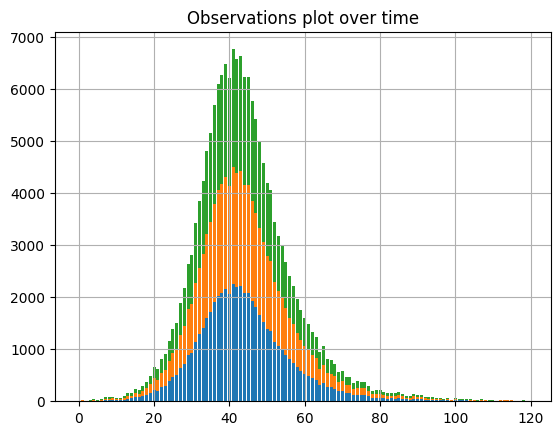

In [11]:
sim.plot_data()

In [12]:
output = sim.run()

Running Particle Filter simulation
• 2015-01-01 00:00:00 to 2015-04-30 00:00:00 (120 days)
• 250 particles

Simulation completed in 196.04s

Parameters estimated: ['beta']


In [20]:
output.model_data.shape

(120, 3)

In [21]:
output.true_data.shape

(120, 3)

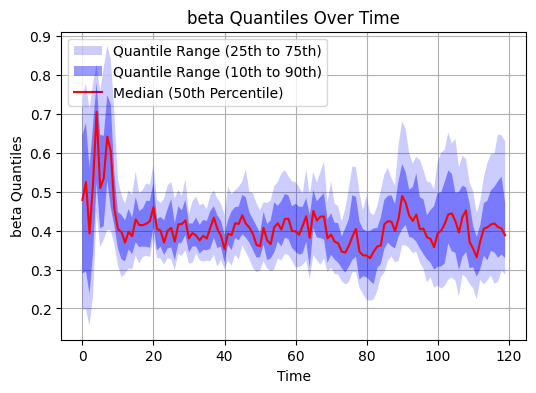

In [ ]:
output.plot.params_plot(parameter="beta", node_index=0)

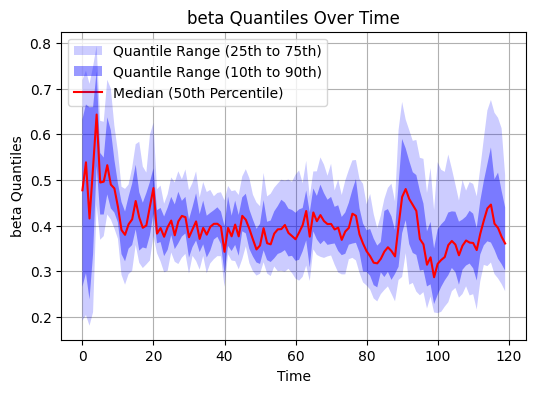

In [ ]:
output.plot.params_plot(parameter="beta", node_index=1)

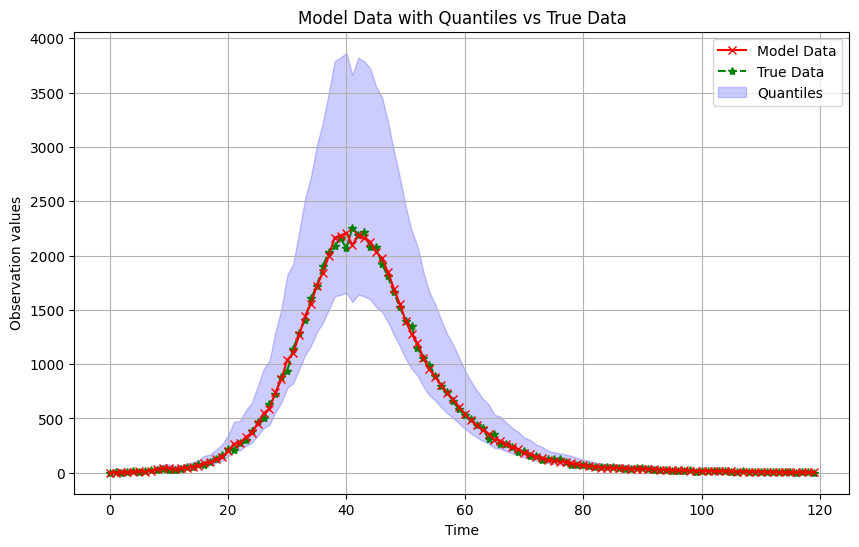

In [27]:
output.plot.model_fit(node_index=0)

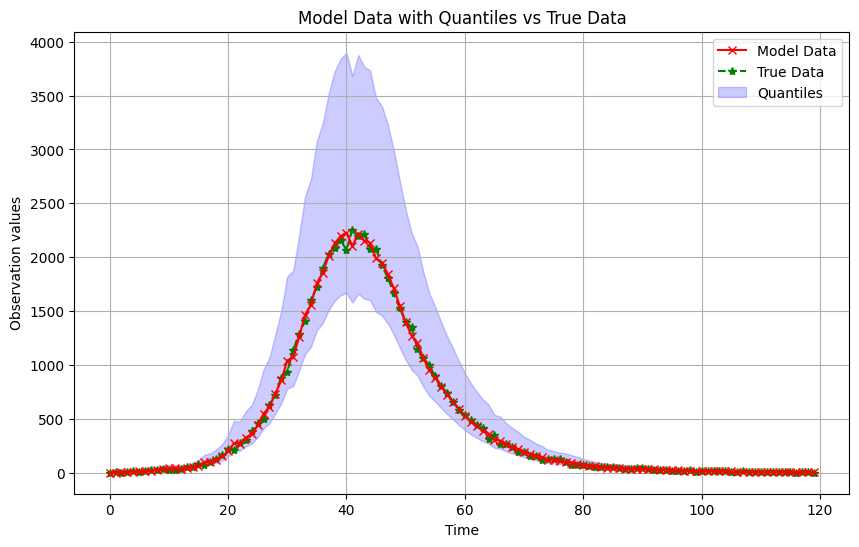

In [28]:
output.plot.model_fit(node_index=1)

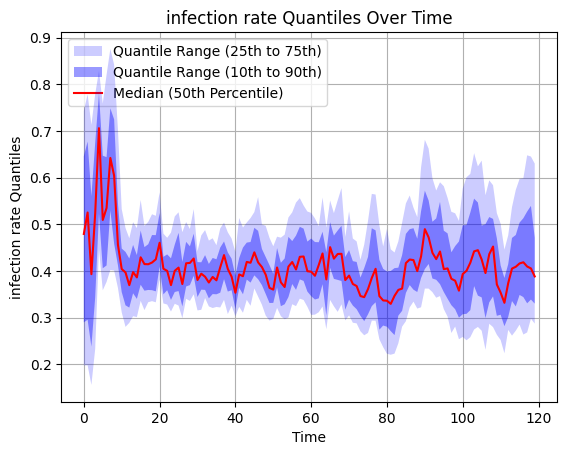

In [18]:
plots.params_plot(output=output, parameter="infection rate", node_index=0)

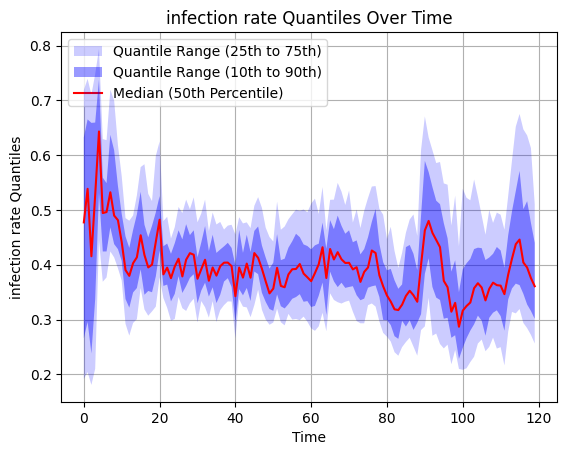

In [19]:
plots.params_plot(output=output, parameter="infection rate", node_index=1)

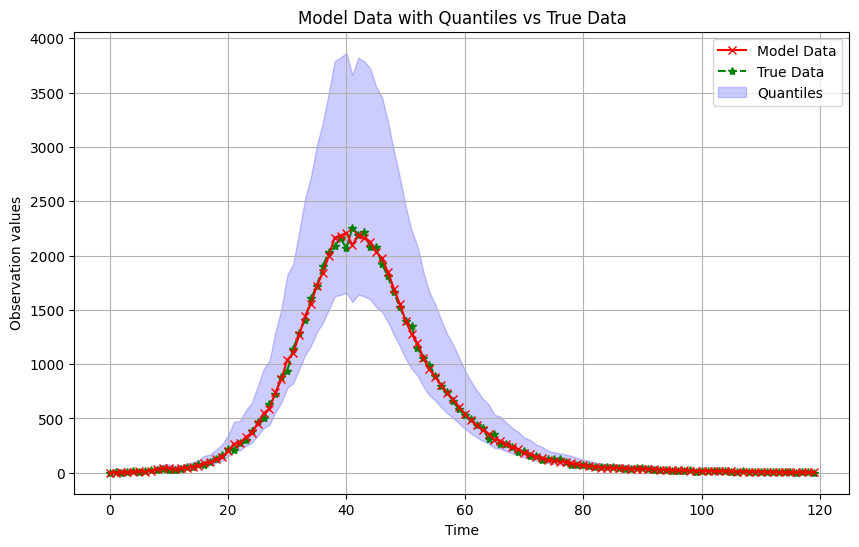

In [25]:
plots.model_fit(output=output, node_index=0)

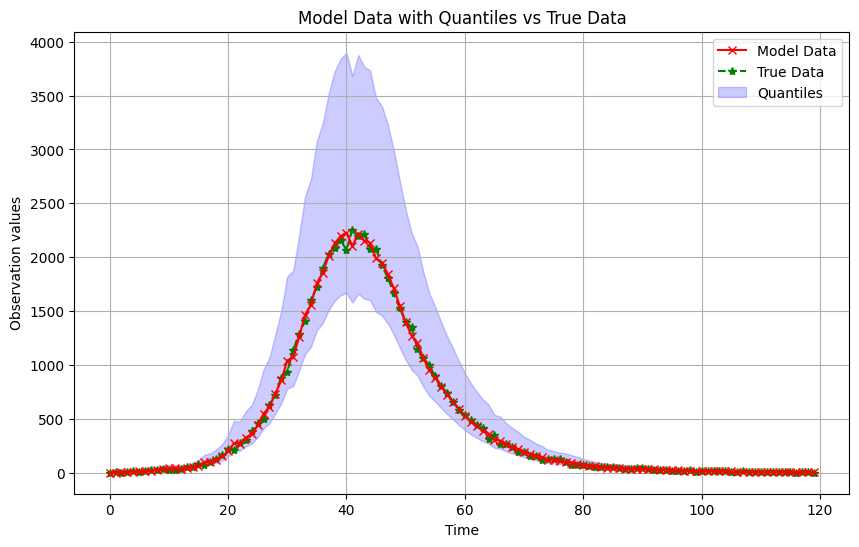

In [26]:
plots.model_fit(output=output, node_index=1)